#  The Battle of the Neighborhoods 

## A new Bulgarian restaurant in Bucharest

### Introduction
This project is an attempt to adequately answer the question where would I open a restaurant in Bucharest,Romania
It would consist of the following tasks:
1. Conversion of address data into their equivalent latitude and longitude values.
2. The dataset that will be used is provided by this wikipedia URL - https://en.wikipedia.org/wiki/Category:Districts_of_Bucharest
3. Foursquare API will be used as means to get the venue locations and the customer's feedback
4. K-means and Agglomorative algorithms will be used as clustering tools
5. Folium will be used for visualisation purposes

### Table of contents
1. Download and Explore Neigborhood Dataset
2. Load and Analyze Venues of Neighborhoods in Bucharest
3. Cluster Neighborhoods using Agglomerative Clustering 
4. Discussion
5. Conclusion

## 1. Download and Explore Neighborhood Dataset

### Import libraries

In [1]:
!pip install geopy    
!pip install folium   
!pip install geocoder

     |████████████████████████████████| 92kB 5.9MB/s eta 0:00:011
     |████████████████████████████████| 102kB 6.5MB/s ta 0:00:011


In [2]:
import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt 
import json
from geopy.geocoders import Nominatim
import requests 
from pandas.io.json import json_normalize 

import matplotlib.cm as cm 
import matplotlib.colors as colors 
from sklearn.cluster import KMeans 

import folium
from folium import plugins 
from folium.plugins import HeatMap

from bs4 import BeautifulSoup
import pandas as pd 
import requests 

print ('Done')

Done


In [3]:
# get coordinates of Bucharest
bucharest_address = 'Bucharest, Romania'

geolocator = Nominatim(user_agent="bucharest_explorer")
location = geolocator.geocode(bucharest_address)
latitude = location.latitude
longitude = location.longitude
bucharest_center = [latitude, longitude ]
print('The geograpical coordinate of {} are {}, {}.'.format(bucharest_address, latitude, longitude))

The geograpical coordinate of Bucharest, Romania are 44.4361414, 26.1027202.


In [4]:
# Read Bucharest neighborhood data 
url = "https://en.wikipedia.org/wiki/Category:Districts of Bucharest"
source = requests.get(url).text
soup = BeautifulSoup(source,'lxml')

neighborhoodList = []

# append the data into the list
for row in soup.find_all("div", class_="mw-category")[0].findAll("li"):
    neighborhoodList.append(row.text.replace(', Bucharest',''))
    
df_neighborhood = pd.DataFrame({"Neighborhood": neighborhoodList})
print("There are {} neighborhoods in {}".format(df_neighborhood.shape[0], bucharest_address))

There are 40 neighborhoods in Bucharest, Romania


#### Extract the data from Wikipedia

In [5]:

# Read Bucharest sector data from wikipedia
url = "https://en.wikipedia.org/wiki/Sectors of Bucharest"
source = requests.get(url).text
soup = BeautifulSoup(source,'lxml')

sectorPopList = []
sectorPopulationList = []

for row in soup.find_all("tbody"):
    header = str(row.findAll("th"))
    if "Population (October 2011)" in header:
        i = 0
        for td in row.find_all("td"):
            i+=1
            if i==2: 
                sectorPopList.append(td.text.replace("\n",""))
            if i==3: 
                sectorPopulationList.append(td.text.replace("\n",""))    
                i=0

df_sectorPop = pd.DataFrame({"Sector": sectorPopList, "Population": sectorPopulationList})

sectorNeigList =[]
sectorNeigborList =[]

for row in soup.find_all("ul"):
    if sectorPopList[0] in  row.text:
        for s in row.text.split("\n"):
            sectorNeigList.append(s.split(":")[0])
            sectorNeigborList.append(s.split(":")[1])
    
df_sector= pd.DataFrame({"Sector": sectorNeigList, "Neigborhoods": sectorNeigborList}).merge(df_sectorPop,on='Sector' )

print("There are {} Sector in {}".format(df_sector.shape[0], bucharest_address))
df_sector

There are 6 Sector in Bucharest, Romania


,Sector,Neigborhoods,Population
0,Sector 1,"Dorobanți, Băneasa, Aviației, Pipera, Aviator...","225,454"
1,Sector 2,"Pantelimon, Colentina, Iancului, Tei, Floreas...","345,370"
2,Sector 3,"Vitan, Dudești, Titan, Centrul Civic, Balta A...","385,439"
3,Sector 4,"Berceni, Olteniței, Văcărești, Timpuri Noi, T...","287,828"
4,Sector 5,"Rahova, Ferentari, Giurgiului, Cotroceni, 13 ...","271,575"
5,Sector 6,"Giulești, Crângași, Drumul Taberei, Militari,...","367,760"


In [6]:
def getSector(row):
    for i in range(df_sector.shape[0]):
        if row["Neighborhood"] in  df_sector.iloc[i].Neigborhoods:
            return pd.Series([df_sector.iloc[i].Sector, df_sector.iloc[i].Population], index = ['Sector','SectorPopulation'])

df_neighborhood[["Sector","SectorPopulation"]] =df_neighborhood.apply(getSector, axis=1)
df_neighborhood.head(5)

,Neighborhood,Sector,SectorPopulation
0,Aviației,Sector 1,"225,454"
1,Băneasa,Sector 1,"225,454"
2,Berceni,Sector 4,"287,828"
3,Bucureștii Noi,Sector 1,"225,454"
4,Centrul Civic,Sector 3,"385,439"


In [7]:
# define a function to get coordinates
import geocoder
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, {}'.format(neighborhood,bucharest_address))
        lat_lng_coords = g.latlng
    return lat_lng_coords

coords = [ get_latlng(neighborhood) for neighborhood in df_neighborhood["Neighborhood"].tolist() ]

df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

# merge the coordinates into the original dataframe
df_neighborhood['Latitude'] = df_coords['Latitude']
df_neighborhood['Longitude'] = df_coords['Longitude']
print("Geographical coordinates of five neighborhoods are as below")
df_neighborhood.head()

Geographical coordinates of five neighborhoods are as below


,Neighborhood,Sector,SectorPopulation,Latitude,Longitude
0,Aviației,Sector 1,"225,454",44.485790,26.101219
1,Băneasa,Sector 1,"225,454",44.494012,26.080358
2,Berceni,Sector 4,"287,828",44.386430,26.128490
3,Bucureștii Noi,Sector 1,"225,454",44.480413,26.042807
4,Centrul Civic,Sector 3,"385,439",44.434300,26.094660


In [26]:
#create map of Bucharest neighborhoods using latitude and longitude values
map_bucharest= folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng,  neighborhood in zip(df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bucharest)  
    
map_bucharest

In [9]:
CLIENT_ID = '0UM5G22BJI21AWN0PROOSYJH0KOZ45VGT2F4XSIDDEYWJ4J4' # your Foursquare ID
CLIENT_SECRET = 'PBQ3LXNUVEOMKVBPH1VXDBCZSNPE5ZMVBX4OZCTXFLVCULQE' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 0UM5G22BJI21AWN0PROOSYJH0KOZ45VGT2F4XSIDDEYWJ4J4
CLIENT_SECRET:PBQ3LXNUVEOMKVBPH1VXDBCZSNPE5ZMVBX4OZCTXFLVCULQE


In [10]:
LIMIT = 100

def getNeighborhoodVenues( latitude, longitude,neighborhood, radius=1000 ):
    venues = []
    for lat, long, neighborhood in zip(latitude, longitude ,neighborhood):

        # create the API request URL
        url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            long,
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        for venue in results:
            venues.append((
                neighborhood,
                lat, 
                long, 
                venue['venue']['name'], 
                venue['venue']['id'], 
                venue['venue']['location']['lat'], 
                venue['venue']['location']['lng'],  
                venue['venue']['location']['distance'],  
                venue['venue']['categories'][0]['name']))
    
    # convert the venues list into a DataFrame
    venues = pd.DataFrame(venues)
    # define the column names
    venues.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueId', 'VenueLatitude', 'VenueLongitude','VenueDistance','VenueCategory']
            
    return venues 

neighborhood_venues = getNeighborhoodVenues (df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhood'] )

print('There are {} unique venue categories. Some of them are as below:'.format(len(neighborhood_venues['VenueCategory'].unique())))
neighborhood_venues.head()

There are 224 unique venue categories. Some of them are as below:


,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory
0,Aviației,44.48579,26.101219,ibis Styles Bucharest Erbas,5bbb782175dcb7002cc15ee7,44.483963,26.097134,382,Hotel
1,Aviației,44.48579,26.101219,LIDL,583956246d349d0574eb02ac,44.488396,26.094375,616,Supermarket
2,Aviației,44.48579,26.101219,Mega Image Concept Store,56348b62498e53f51a0a4e0e,44.479783,26.102568,677,Supermarket
3,Aviației,44.48579,26.101219,Starbucks,525fd077498eed1c5a52c1d6,44.478522,26.102503,815,Coffee Shop
4,Aviației,44.48579,26.101219,Flying Pig,58a2fc95d0bb3e516a2363b7,44.479454,26.102837,716,Burger Joint


In [11]:
print('Top 10 distinct venue counts are as below')
neighborhood_venues[['VenueId','VenueCategory']].drop_duplicates().groupby('VenueCategory').count()[['VenueId']].rename(columns={"VenueId": "Count"}).sort_values(by=['Count'], ascending=False)[:10]

Top 10 distinct venue counts are as below


,Count
VenueCategory,
Café,68
Restaurant,66
Coffee Shop,59
Italian Restaurant,54
Supermarket,52
Pizza Place,49
Hotel,41
Gym,39
Gym / Fitness Center,39


In [12]:
restaurant_list =['Restaurant', 'Burger Joint','Café','Fried Chicken Joint','Pizza Place']
bulgarian_restaurant_list = ['Bulgarian Restaurant', 'Doner Restaurant']

# Filter restaurants 
    
neighborhood_venues['RestFlag']=False
for restCat in restaurant_list:
    neighborhood_venues['RestFlag'] = neighborhood_venues['RestFlag'] | neighborhood_venues['VenueCategory'].str.contains(restCat)
    
neighborhood_restaurants = neighborhood_venues[neighborhood_venues['RestFlag'] == True].iloc[:,:-1]
bulgarian_restaurants = neighborhood_restaurants[ neighborhood_restaurants['VenueCategory'].isin(bulgarian_restaurant_list) ]
other_restaurants = neighborhood_restaurants[ ~neighborhood_restaurants['VenueCategory'].isin(bulgarian_restaurant_list) ]

print('Total number of restaurants:', len(neighborhood_restaurants['VenueId'].unique()))
print('Total number of Bulgarian restaurants:', len(bulgarian_restaurants['VenueId'].unique()))
print('Percentage of Bulgarian restaurants: {:.2f}%'.format(len(bulgarian_restaurants['VenueId'].unique()) / len(neighborhood_restaurants['VenueId'].unique()) * 100))

Total number of restaurants: 495
Total number of Bulgarian restaurants: 10
Percentage of Bulgarian restaurants: 2.02%


27 neighborhoods do not have any Bulgarian restaurant


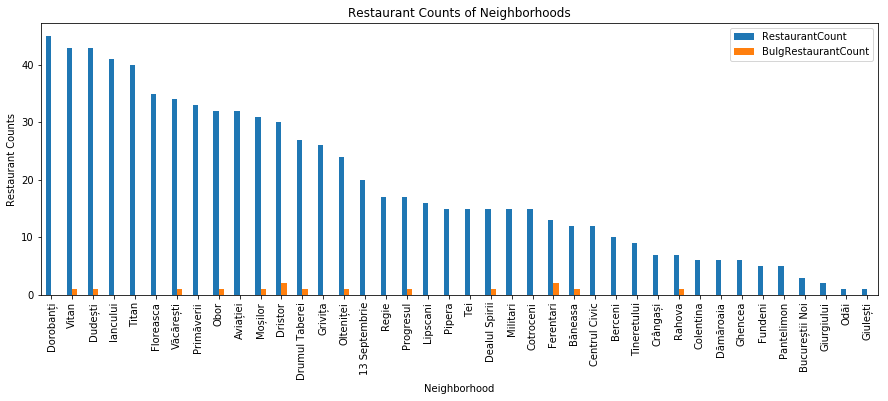

In [13]:
# get counts of restaurants in each Neighborhood
df_rest_counts =  neighborhood_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "RestaurantCount"})[['RestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(neighborhood_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_rest_counts = df_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'RestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_rest_counts.reset_index(inplace=True)

#####
# get counts of Bulgarian restaurants in each Neighborhood
df_bulg_rest_counts =  bulgarian_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "BulgRestaurantCount"})[['BulgRestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(bulgarian_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_bulg_rest_counts = df_bulg_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'BulgRestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_bulg_rest_counts.reset_index(inplace=True)
df_rest_counts= df_rest_counts.merge(df_bulg_rest_counts).set_index('Neighborhood')
df_rest_counts= df_rest_counts.sort_values(by=['RestaurantCount'],ascending =False)

print('{} neighborhoods do not have any Bulgarian restaurant'.format(len(noRestList)))
######
#Draw graph
df_rest_counts[['RestaurantCount','BulgRestaurantCount']].plot(kind='bar',figsize=(15,5))
plt.title('Restaurant Counts of Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Restaurant Counts')
plt.show()

In [14]:
def getVenueRaitings(venues):
    
    raitings = []
    likes =[]
    for venueId in venues:

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venueId, CLIENT_ID, CLIENT_SECRET, VERSION)
        result = requests.get(url).json()
        try:
            rating = result['response']['venue']['rating']
            likes = result['response']['venue']['likes']['count']
        except:
            rating = None
            likes = None
        
        raitings.append((venueId, rating,likes))
 
    # convert the venues list into a DataFrame
    rating = pd.DataFrame(raitings)
    # define the column names
    rating.columns = ['VenueId', 'VenueRating','VenueLikes']

    return rating    

restaurants_raitings = getVenueRaitings(neighborhood_restaurants['VenueId'].drop_duplicates())
restaurants_raitings.head()

,VenueId,VenueRating,VenueLikes
0,58a2fc95d0bb3e516a2363b7,8.2,22.0
1,55b8a459498efbbb6ca3526d,8.0,9.0
2,53623e44498ed583ede334f5,7.6,130.0
3,58bbf8764f1069627380fed5,7.5,22.0
4,55859bef498eca16beae6deb,7.5,11.0


In [15]:
#merge ratings to restaurants 
neighborhood_restaurants = neighborhood_restaurants.merge(restaurants_raitings)
neighborhood_restaurants.head()

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,Aviației,44.485790,26.101219,Flying Pig,58a2fc95d0bb3e516a2363b7,44.479454,26.102837,716,Burger Joint,8.2,22.0
1,Floreasca,44.476308,26.103289,Flying Pig,58a2fc95d0bb3e516a2363b7,44.479454,26.102837,351,Burger Joint,8.2,22.0
2,Aviației,44.485790,26.101219,Toàn's,55b8a459498efbbb6ca3526d,44.478370,26.103411,844,Vietnamese Restaurant,8.0,9.0
3,Floreasca,44.476308,26.103289,Toàn's,55b8a459498efbbb6ca3526d,44.478370,26.103411,229,Vietnamese Restaurant,8.0,9.0
4,Aviației,44.485790,26.101219,trickSHOT,53623e44498ed583ede334f5,44.478378,26.103135,838,Restaurant,7.6,130.0


In [16]:
#merge ratings to Bulgarian restaurants 
bulgarian_restaurants = bulgarian_restaurants.merge(restaurants_raitings)
bulgarian_restaurants.head(5)

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,Băneasa,44.494012,26.080358,Shaormeria Băneasa,5137a298e4b0523475c45b54,44.494460,26.080462,50,Doner Restaurant,7.0,40.0
1,Dealul Spirii,44.422982,26.069593,Mesopotamia,5415dbc3498efe97bd5e2f89,44.417890,26.072145,602,Doner Restaurant,NaN,NaN
2,Ferentari,44.412870,26.073428,Mesopotamia,5415dbc3498efe97bd5e2f89,44.417890,26.072145,568,Doner Restaurant,NaN,NaN
3,Progresul,44.423933,26.067859,Mesopotamia,5415dbc3498efe97bd5e2f89,44.417890,26.072145,754,Doner Restaurant,NaN,NaN
4,Dristor,44.420090,26.139440,Dristor Kebap,4c4db18f67929c74a4dc579b,44.420221,26.137363,165,Doner Restaurant,NaN,NaN


In [27]:
bucharest_center = [latitude, longitude]
map_restaurant= folium.Map(location=bucharest_center, zoom_start=12)
df_neighborhood_noturkrest = df_neighborhood[df_neighborhood['Neighborhood'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_bucharest) 
HeatMap(neighborhood_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(bucharest_center).add_to(map_bucharest)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig, name in zip(bulgarian_restaurants['VenueLatitude'], bulgarian_restaurants['VenueLongitude'], bulgarian_restaurants['Neighborhood'], bulgarian_restaurants['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)
       
raiting_lt_7 = bulgarian_restaurants[bulgarian_restaurants['VenueRating'] <7]
for lat, lon, neig, name in zip(raiting_lt_7['VenueLatitude'], raiting_lt_7['VenueLongitude'], raiting_lt_7['Neighborhood'], raiting_lt_7['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)        
map_restaurant

In [28]:
bucharest_center = [latitude, longitude]
map_restaurant= folium.Map(location=bucharest_center, zoom_start=12)

df_neighborhood_noturkrest = df_neighborhood[df_neighborhood['Neighborhood'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_bucharest) 
HeatMap(neighborhood_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(bucharest_center).add_to(map_bucharest)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig in zip(df_neighborhood_noturkrest['Latitude'], df_neighborhood_noturkrest['Longitude'], df_neighborhood_noturkrest['Neighborhood']):
    label = folium.Popup(str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='cyan',
        fill=True,
        fill_color='cyan',
        fill_opacity=0.7).add_to(map_restaurant)
map_restaurant

In [20]:
# one hot encoding
onehot = pd.get_dummies(neighborhood_venues[['VenueCategory']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
onehot['Neighborhood'] = neighborhood_venues['Neighborhood']

venues_grouped = onehot.groupby(["Neighborhood"]).sum().reset_index()

# move neighborhood column to the first column and filter only restaurant columns 
fixed_columns =['Neighborhood'] + list(neighborhood_venues['VenueCategory'].unique())
venues_grouped = venues_grouped[fixed_columns]

print("{}  neighborhoods' venue category are shown in {} columns as below".format(venues_grouped.shape[0],venues_grouped.shape[1]-1))
venues_grouped.head()

40  neighborhoods' venue category are shown in 224 columns as below


,Neighborhood,Hotel,Supermarket,Coffee Shop,Burger Joint,Dessert Shop,Roof Deck,Grocery Store,Vietnamese Restaurant,Salad Place,Salon / Barbershop,Bookstore,Beer Garden,Gym / Fitness Center,Restaurant,Steakhouse,Café,Pie Shop,Bakery,Shopping Mall,Italian Restaurant,Clothing Store,Sushi Restaurant,Turkish Restaurant,Toy / Game Store,Lebanese Restaurant,Sandwich Place,Spanish Restaurant,Casino,Pizza Place,Middle Eastern Restaurant,Event Space,Indoor Play Area,Lounge,Eastern European Restaurant,Fried Chicken Joint,Stadium,Romanian Restaurant,Mongolian Restaurant,Tennis Stadium,Chinese Restaurant,Cosmetics Shop,Men's Store,Wine Shop,Cocktail Bar,Gym,Doner Restaurant,Vegetarian / Vegan Restaurant,Lake,Nightclub,Park,Theme Restaurant,Tunnel,Farmers Market,Bed & Breakfast,Pharmacy,Food & Drink Shop,Nature Preserve,Fast Food Restaurant,Electronics Store,Fountain,Metro Station,Gas Station,Athletics & Sports,Spa,Light Rail Station,Gym Pool,Korean Restaurant,Mexican Restaurant,Dog Run,Bistro,Outdoor Sculpture,Gastropub,Theater,Monastery,Indie Theater,Skating Rink,Beer Bar,Used Bookstore,Ice Cream Shop,Chocolate Shop,Tea Room,Art Museum,Bar,Wine Bar,Concert Hall,Plaza,Rock Club,Swiss Restaurant,Hostel,Historic Site,Art Gallery,Tattoo Parlor,Mediterranean Restaurant,Music Venue,Church,History Museum,Gourmet Shop,Boutique,French Restaurant,Garden,Hardware Store,Discount Store,Antique Shop,Arts & Crafts Store,Bus Station,Auto Dealership,Gift Shop,Tennis Court,Accessories Store,Jazz Club,Market,Opera House,Hotel Bar,Pub,Indian Restaurant,Music Store,Pool,Pedestrian Plaza,Indie Movie Theater,Australian Restaurant,IT Services,Cafeteria,Scenic Lookout,Department Store,Cupcake Shop,Climbing Gym,Soccer Stadium,Miscellaneous Shop,Convenience Store,Furniture / Home Store,Outlet Mall,Mobile Phone Shop,Flower Shop,Fish Market,Japanese Restaurant,Juice Bar,Scandinavian Restaurant,Cheese Shop,Asian Restaurant,Modern European Restaurant,Seafood Restaurant,Creperie,Fruit & Vegetable Store,German Restaurant,Molecular Gastronomy Restaurant,Hookah Bar,American Restaurant,Drugstore,Auto Workshop,Pet Store,Multiplex,Eye Doctor,Skate Park,Greek Restaurant,Pool Hall,Water Park,Brewery,Sports Club,Veterinarian,Health & Beauty Service,Health Food Store,Camera Store,Bagel Shop,Falafel Restaurant,Diner,Flea Market,Portuguese Restaurant,Science Museum,Sporting Goods Shop,Lingerie Store,Cable Car,Tram Station,Boxing Gym,Soccer Field,Museum,Food Truck,Buffet,Movie Theater,Kebab Restaurant,Exhibit,Snack Place,Public Art,Auto Garage,Women's Store,Palace,Cultural Center,Football Stadium,Print Shop,Shoe Store,Intersection,BBQ Joint,Hungarian Restaurant,Karaoke Bar,Optical Shop,ATM,Donut Shop,Beach,Food,Go Kart Track,Souvlaki Shop,Track,Recreation Center,Bike Shop,Bike Rental / Bike Share,Basketball Court,Paper / Office Supplies Store,Bowling Alley,Sports Bar,Laundromat,Baby Store,Comfort Food Restaurant,Taco Place,Watch Shop,Fish & Chips Shop,Recording Studio,Playground,Betting Shop,Jewelry Store,Soup Place,Circus,Dance Studio,Pet Café,Leather Goods Store,Gaming Cafe
0,13 Septembrie,4,1,1,0,0,0,1,0,0,0,0,0,3,5,1,4,0,0,0,1,2,0,0,0,0,0,0,1,0,0,0,0,2,0,1,0,2,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,2,1,1,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,1,0,0,1,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,1,1,0,0,0,0,0,0,0,0,0
1,Aviației,4,4,3,3,2,1,1,1,1,1,1,1,2,6,3,5,1,4,1,1,3,2,1,1,2,1,1,1,4,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
# create a new dataframe with most common venue catrgories
def return_most_common_venues(row, num_top_venues):
    row_categories = row
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

columns = ['Neighborhood','Total Number of Venues']
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

# create a new dataframe
venues_most = pd.DataFrame(columns = columns)

for ind in range(venues_grouped.shape[0]):
    venues_most.loc[ind, 'Neighborhood'] = venues_grouped.iloc[ind].Neighborhood
    venues_most.loc[ind, 'Total Number of Venues'] = venues_grouped.iloc[ind,1:].sum()
    venues_most.iloc[ind, 2:] = return_most_common_venues(venues_grouped.iloc[ind, 1:], num_top_venues)

venues_most.head()

,Neighborhood,Total Number of Venues,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,13 Septembrie,71,Restaurant,Hotel,Café,Plaza,Pub,Gym / Fitness Center,Lounge,Romanian Restaurant,Tea Room,Comfort Food Restaurant
1,Aviației,79,Restaurant,Café,Pizza Place,Bakery,Hotel,Supermarket,Burger Joint,Steakhouse,Coffee Shop,Clothing Store
2,Berceni,30,Eastern European Restaurant,Pizza Place,Grocery Store,Gym / Fitness Center,Coffee Shop,Gym,Farmers Market,Hotel,Lebanese Restaurant,Park
3,Bucureștii Noi,14,Gym,Light Rail Station,Restaurant,Dog Run,Mexican Restaurant,Korean Restaurant,Park,Gym Pool,Spa,Farmers Market
4,Băneasa,26,Hotel,Italian Restaurant,Café,Romanian Restaurant,Pizza Place,Middle Eastern Restaurant,Gym,Doner Restaurant,Vegetarian / Vegan Restaurant,Lake


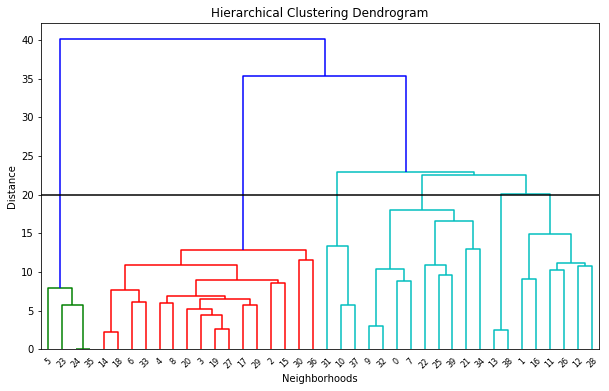

In [22]:
import scipy.cluster.hierarchy as shc

data = venues_grouped.iloc[:,3:]
plt.figure(figsize=(10, 6))   
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Neighborhoods')
plt.ylabel('Distance')
plt.axhline(y=20, c='k')
dend = shc.dendrogram(shc.linkage(data, method='ward'))

In [23]:
from sklearn.cluster import AgglomerativeClustering

kclusters= 6
cluster = AgglomerativeClustering(n_clusters=kclusters, affinity='euclidean', linkage='ward')  
clusterresult = cluster.fit_predict(data)

venues_grouped['NeighborhoodCluster'] = clusterresult
venues_cluster= df_neighborhood.merge(venues_grouped[['Neighborhood','NeighborhoodCluster']])
venues_cluster =venues_cluster.merge(venues_most[['Neighborhood','1st Most Common Restaurant','2nd Most Common Restaurant','3rd Most Common Restaurant']])
venues_cluster.head()

,Neighborhood,Sector,SectorPopulation,Latitude,Longitude,NeighborhoodCluster,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant
0,Aviației,Sector 1,"225,454",44.485790,26.101219,1,Restaurant,Café,Pizza Place
1,Băneasa,Sector 1,"225,454",44.494012,26.080358,2,Hotel,Italian Restaurant,Café
2,Berceni,Sector 4,"287,828",44.386430,26.128490,2,Eastern European Restaurant,Pizza Place,Grocery Store
3,Bucureștii Noi,Sector 1,"225,454",44.480413,26.042807,2,Gym,Light Rail Station,Restaurant
4,Centrul Civic,Sector 3,"385,439",44.434300,26.094660,3,Coffee Shop,Hotel,Theater


In [29]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster, sector,SectorPopulation  in zip(venues_cluster['Latitude'], venues_cluster['Longitude'], venues_cluster['Neighborhood'], venues_cluster['NeighborhoodCluster'], venues_cluster['Sector'],venues_cluster['SectorPopulation']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster)+ ' ' + str(sector) + ' ' + str(SectorPopulation), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
folium.Marker(bucharest_center).add_to(map_clusters)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_clusters)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_clusters)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_clusters)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_clusters)         
map_clusters

In [25]:
print(venues_cluster.groupby(['NeighborhoodCluster','1st Most Common Restaurant' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"}))

venues_cluster.groupby(['NeighborhoodCluster','2nd Most Common Restaurant' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"})

                                                 Neighborhood Count
NeighborhoodCluster 1st Most Common Restaurant                     
0                   Bus Station                                   1
                    Café                                          1
                    Coffee Shop                                   1
                    Hotel                                         1
                    Italian Restaurant                            2
                    Pub                                           1
                    Restaurant                                    1
                    Supermarket                                   1
1                   Coffee Shop                                   1
                    Gym                                           1
                    Italian Restaurant                            1
                    Pizza Place                                   2
                    Restaurant                  

Neighborhood Count
NeighborhoodCluster 2nd Most Common Restaurant                    
0                   Bus Station                                  1
                    Café                                         1
                    Gym                                          1
                    Hotel                                        1
                    Italian Restaurant                           1
                    Pub                                          1
                    Restaurant                                   2
                    Supermarket                                  1
1                   Bakery                                       1
                    Café                                         1
                    Clothing Store                               1
                    Gym / Fitness Center                         1
                    Supermarket                                  2
2                   Beach                                        1
                    Burger Joint                                 1
                    Café                                         1
                    Dessert Shop                                 1
                    Fast Food Restaurant                         1
                    Grocery Store                                1
                    Italian Restaurant                           1
                    Light Rail Station                           1
                    Museum                                       1
                    Park                                         2
                    Pharmacy                                     1
                    Pizza Place                                  1
                    Restaurant                                   1
                    Supermarket                                  2
3                   Hotel                                        4
4                   Coffee Shop                                  3
5                   Italian Restaurant                           1
                    Lounge                                       1

The color/cluster combination is as follows:

1. Cluster 0 Red 
2. Cluster 1 Purple 
3. Cluster 2 Blue 
4. Cluster 3 Cyan 
5. Cluster 4 Green 
6. Cluster 5 Orange



### Discussion

Firstly, lets state that I assume that the data provided by Foursquare is accurate and depicts the real picture of the restaurant scene in Bucharest. I am basing my analysis on that assumption. We can also ask the question why is there no restaurant in that location? Maybe there's a noisy highway or a criminal area and that's why there's no restaurant there. As generally we are excluding the socio-economic sitiation in the area we should be aware that other factors can fail our business that can be a topic of another analysis.

Looking at our first graph, the bar chart, we can see that 26 neighborhoods do not have a Bulgarian restaurant and thats our first clue. We discard the other 14 neighborhoods that do indeed have a Bulgarian restaurant as we want exclusivity and less competition.
Now what our heatmap suggests , is that the region in the north-east of the city has the lesser quantity of restaurants in comparison with the other parts of the city. We will take this argument lightly as there may be a sitiation where thats a criminal neighborhood or any other problem.We don't necessarily want a place where there are no restaurants at all,rather we want a location where a Bulgarian restaurant will be something different and the consumers can be intrigued.
The last graph shows us that there is a lack of restaurants in cluster 2 and could be a good place to set up a new restaurant



### Conclusion

All in all, we could select several locations for our new Bulgarian restaurant.

The first option in my opinion should be a neighborhood with the name of Crângași which is in Cluster 2 Sector 6.There is no Bulgarian restaurant around and looking at the bar chart there aren't many restaurants in general. Sector 6 also has the biggest population(367760) which increases the probability of a successful business. 

The second option shall be Regie in cluster 0,sector 6 as there is no Bulgarian restaurant around and its location shows a close proximity to the city centre.While there are more restaurants in that cluster than cluster 2 the size of the population makes me believe that the restaurant can be profitable.

The third and final option is Bucureștii Noi in cluster 2 sector 1. It's not far away from the city centre and there are no Bulgarian restaurants in close proximity. 
